In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.optimize as optimize
# from sklearn.decomposition import PCA
from scipy.linalg import eig

In [2]:
df_raw = pd.read_excel("bond_data.xlsx")

In [3]:
# data cleaning
rename_column = ['ISIN', 'Issue Date', 'Maturity Date', 'Coupon rate']

for i in range(10):
    rename_column.append( str(datetime.date(df_raw.columns[4:][i])) )

df_raw.columns = rename_column
df_raw['Maturity Date'] = pd.to_datetime(df_raw['Maturity Date'])
df_raw['Issue Date'] = pd.to_datetime(df_raw['Issue Date'])

selected_bonds_for_yield_curve = ['CA135087L286', 'CA135087L773', 'CA135087M359', 'CA135087M920',
                                  'CA135087J967', 'CA135087K528', 'CA135087K940', 'CA135087L518',
                                  'CA135087L930', 'CA135087M847']
Time_to_maturity = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
df_selected_bonds = df_raw.loc[df_raw['ISIN'].isin(selected_bonds_for_yield_curve)]
df_selected_bonds = df_selected_bonds.sort_values(by = ['Maturity Date']).reset_index(drop=True)
df_selected_bonds['Time to Maturity'] = Time_to_maturity

In [4]:
df_selected_bonds

,ISIN,Issue Date,Maturity Date,Coupon rate,2022-01-10,2022-01-11,2022-01-12,2022-01-13,2022-01-14,2022-01-17,2022-01-18,2022-01-19,2022-01-20,2022-01-21,Time to Maturity
0,CA135087L286,2020-05-04,2022-08-01,0.0025,99.800,99.790,99.78,99.770,99.760,99.720,99.700,99.700,99.720,99.740,0.5
1,CA135087L773,2020-10-26,2023-02-01,0.0025,99.310,99.260,99.29,99.280,99.260,99.180,99.120,99.100,99.150,99.200,1.0
2,CA135087M359,2021-05-14,2023-08-01,0.0025,98.808,98.800,98.78,98.763,98.736,98.610,98.553,98.549,98.558,98.611,1.5
3,CA135087M920,2021-10-22,2024-02-01,0.0075,99.200,99.200,99.16,99.130,99.090,98.920,98.840,98.840,98.830,98.900,2.0
4,CA135087J967,2019-04-05,2024-09-01,0.0150,100.560,100.630,100.62,100.580,100.520,100.290,100.210,100.150,100.170,100.270,2.5
5,CA135087K528,2019-10-11,2025-03-01,0.0125,99.640,99.670,99.61,99.590,99.490,99.250,99.120,99.110,99.100,99.260,3.0
6,CA135087K940,2020-04-03,2025-09-01,0.0050,96.660,96.720,96.77,96.770,96.680,96.430,96.260,96.150,96.190,96.310,3.5
7,CA135087L518,2020-10-09,2026-03-01,0.0025,95.110,95.170,95.12,95.140,95.040,94.750,94.530,94.500,94.520,94.700,4.0
8,CA135087L930,2021-04-16,2026-09-01,0.0100,97.660,97.740,97.67,97.690,97.585,97.240,97.020,96.960,97.000,97.225,4.5
9,CA135087M847,2021-10-15,2027-03-01,0.0125,98.410,98.475,98.40,98.440,98.310,97.955,97.700,97.660,97.685,97.940,5.0


In [5]:
def calculate_zero_coupon_rate(price, T, notional = 100):
    return -np.log(price/notional)/T

def get_bond_spot_rate(bonds_spot_rate, price, coupon_rate, T, notional = 100):
    coupon_payment = coupon_rate * notional * 0.5 # semi-annual
    if T == 0.5:
        bonds_spot_rate.append(calculate_zero_coupon_rate(price, T, notional + coupon_payment))
    else:
        value = price
        coupon_devalue_total = 0
        for t in range(len(bonds_spot_rate)):
            spot_rate_t = bonds_spot_rate[t]
            coupon_devalue_total += coupon_payment * np.exp(-spot_rate_t * Time_to_maturity[t])
        value -= coupon_devalue_total
        bonds_spot_rate.append( -(np.log(value/(notional+coupon_payment)) / T) )
    return bonds_spot_rate

def get_bond_ytm(price, coupon_rate, T, notional = 100):
    coupon_payment = coupon_rate * notional * 0.5 # semi-annual
    bond_tm = Time_to_maturity[:Time_to_maturity.index(T)]
    ytm = lambda y: sum([coupon_payment * np.exp(-y * t) for t in bond_tm]) + \
    ((notional + coupon_payment) * np.exp(-y * T)) - price
    return optimize.newton(ytm, 0.005)

In [6]:
# Calculate spot rate
days = list(df_selected_bonds.columns[4:-1])
yield_curve_days = {}
coupon_rate = list(df_selected_bonds['Coupon rate'])

for day in days:
    prices_day = list(df_selected_bonds[day])
    bonds_spot_rate = []
    
    for i in range(len(prices_day)):
        bonds_spot_rate = get_bond_spot_rate(bonds_spot_rate, prices_day[i], coupon_rate[i], 
                                             Time_to_maturity[i]).copy()
    yield_curve_days[day] = bonds_spot_rate

In [7]:
# Calculate forward rate
forward_curve_days = {}
initial_time = 1
time_point = [2, 3, 4, 5]
for day in days:
    spot_curve = yield_curve_days[day]
    forward_curve = np.zeros(len(time_point))
    for i in range(len(time_point)):
        forward_curve[i] = (spot_curve[time_point[i]*2-1] * time_point[i] - spot_curve[initial_time]) / (time_point[i] - initial_time)
    forward_curve_days[day] = forward_curve

In [8]:
# Calculate YTM
ytm_curve_bond = {}
yield_maturity = {}

for i in range(len(selected_bonds_for_yield_curve)):
    ytm_bond = []
    price_of_bond = list(df_selected_bonds.iloc[i,4:-1])
    time_to_maturity = df_selected_bonds.iloc[i,-1]
    coupon_rate = df_selected_bonds.iloc[i,3]
    
    for price in price_of_bond:
        ytm_bond.append(get_bond_ytm(price, coupon_rate, time_to_maturity))

    ytm_curve_bond[selected_bonds_for_yield_curve[i]] = ytm_bond.copy()


for i in range(len(days)):
    yield_maturity[days[i]] = []
    for bond in ytm_curve_bond:
        yield_maturity[days[i]].append(ytm_curve_bond[bond][i])

In [9]:
for i in range(len(ytm_curve_bond)):
    print("YTM for Bond {}: {}".format(i+1, ytm_curve_bond[selected_bonds_for_yield_curve[i]]))

YTM for Bond 1: [0.006502444142210245, 0.006702854984604068, 0.006903285911263878, 0.007103736926215166, 0.0073042080334844404, 0.008106293466331281, 0.008507456841459126, 0.008507456841459126, 0.008106293466331281, 0.007705210541093192]
YTM for Bond 2: [0.009426686112326865, 0.009930602552777605, 0.009628222227267584, 0.009729005513311843, 0.009930602552777605, 0.010737397242701422, 0.011342920578135629, 0.011544843171460463, 0.011040113092480375, 0.010535637557622128]
YTM for Bond 3: [0.010502869582836444, 0.010556916402295453, 0.010692052612787543, 0.010806939921104947, 0.01098944867943984, 0.011841817109421773, 0.012227770456631341, 0.01225486328937673, 0.012193905963086843, 0.011835047990939929]
YTM for Bond 4: [0.011524687804122337, 0.011524687804122337, 0.011727480427187305, 0.011879628762210393, 0.012082565085828218, 0.012945962377465455, 0.01335278223215092, 0.01335278223215092, 0.013403657940857697, 0.0130476363866292]
YTM for Bond 5: [0.012676829503559377, 0.0123943255376801

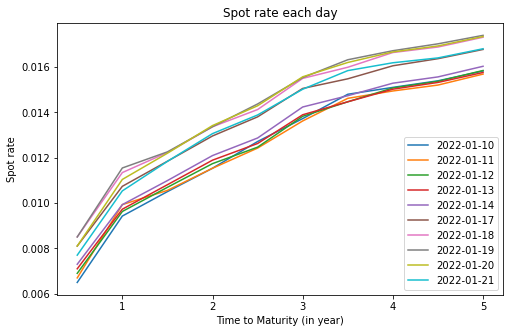

In [10]:
# Plot spot rate
plt.figure(figsize = (8, 5))

for day in days:
    plt.plot(Time_to_maturity, yield_curve_days[day], label = day)

plt.title("Spot rate each day")
plt.xlabel("Time to Maturity (in year)")
plt.ylabel("Spot rate")
plt.legend()
plt.show()

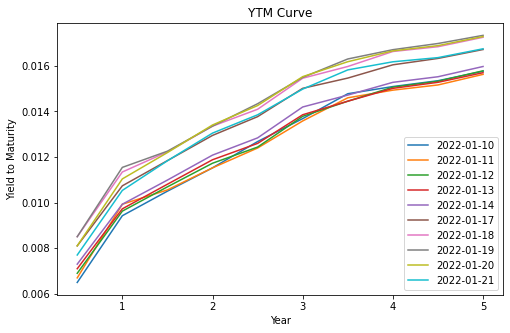

In [11]:
# Plot yield curve
plt.figure(figsize = (8, 5))
for day in days:
    plt.plot(Time_to_maturity, yield_maturity[day], label = day)

plt.title("YTM Curve")
plt.xlabel("Year")
plt.ylabel("Yield to Maturity")
plt.legend()
plt.show()

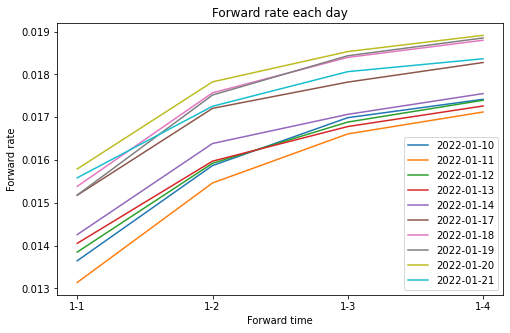

In [12]:
# Plot forward rate
plt.figure(figsize = (8, 5))
x_label = ['1-1', '1-2', '1-3', '1-4']
for day in days:
    plt.plot(x_label, forward_curve_days[day], label = day)

plt.title("Forward rate each day")
plt.xlabel("Forward time")
plt.ylabel("Forward rate")
plt.legend()
plt.show()

In [13]:
# Covariance matrices
matrix_yield = np.zeros([5, 9])
matrix_forward = np.zeros([4, 9])

for i in range(5):
    for j in range(9):
        matrix_yield[i,j] = np.log(yield_maturity[days[j+1]][2*i+1] / yield_maturity[days[j]][2*i+1])


for i in range(4):
    for j in range(9):
        matrix_forward[i,j] = np.log(forward_curve_days[days[j+1]][i] / forward_curve_days[days[j]][i])

In [14]:
nmatrix_yield = (matrix_yield.T - np.mean(matrix_yield.T, axis = 0)).T
nmatrix_forward = (matrix_forward.T - np.mean(matrix_forward.T, axis = 0)).T

In [15]:
np.mean(nmatrix_yield, axis = 1)

array([ 1.54197642e-18, -1.54197642e-18,  7.70988212e-19,  7.70988212e-19,
        0.00000000e+00])

In [16]:
Cov_yield = np.cov(nmatrix_yield)
Cov_forward = np.cov(nmatrix_forward)

In [17]:
Cov_yield

array([[0.00205392, 0.00082329, 0.00077153, 0.0007526 , 0.00072205],
       [0.00082329, 0.00068826, 0.00065362, 0.00058847, 0.00056493],
       [0.00077153, 0.00065362, 0.00065796, 0.00059417, 0.00057516],
       [0.0007526 , 0.00058847, 0.00059417, 0.00056649, 0.00054292],
       [0.00072205, 0.00056493, 0.00057516, 0.00054292, 0.00052372]])

In [18]:
Cov_forward

array([[0.00108327, 0.0007757 , 0.00057856, 0.0005286 ],
       [0.0007757 , 0.00070255, 0.00057689, 0.00054971],
       [0.00057856, 0.00057689, 0.00053297, 0.00050556],
       [0.0005286 , 0.00054971, 0.00050556, 0.00048617]])

In [19]:
eigenval_yield, eigenvec_yield = eig(Cov_yield)
eigenval_forward, eigenvec_forward = eig(Cov_forward)

In [21]:
eigenval_yield.real[0]

0.0037591708312200247

In [22]:
eigenval_yield.real[0] / np.sum(eigenval_yield.real)

0.8371680211087287

In [23]:
eigenvec_yield[:,0]

array([-0.66934629, -0.39383128, -0.38291881, -0.36059567, -0.34672239])

In [24]:
eigenval_forward.real[0]

0.0025153627574945638

In [25]:
eigenvec_forward[:,0]

array([0.60935609, 0.52278311, 0.43415682, 0.40852274])

In [26]:
eigenval_forward.real[0] / np.sum(eigenval_forward.real)

0.8967534069575255

In [27]:
eigenval_forward.real[0] * eigenvec_forward[:,0]

array([0.00153275, 0.00131499, 0.00109206, 0.00102758])

In [28]:
PC1 = eigenval_yield.real[0] * eigenvec_yield[:,0]
PC2 = eigenval_yield.real[1] * eigenvec_yield[:,1]
x_axis = [1, 2, 3, 4, 5]

In [29]:
PC1

array([-0.00251619, -0.00148048, -0.00143946, -0.00135554, -0.00130339])

In [30]:
PC2

array([-0.0004982 ,  0.00022578,  0.00025907,  0.00020828,  0.00020259])

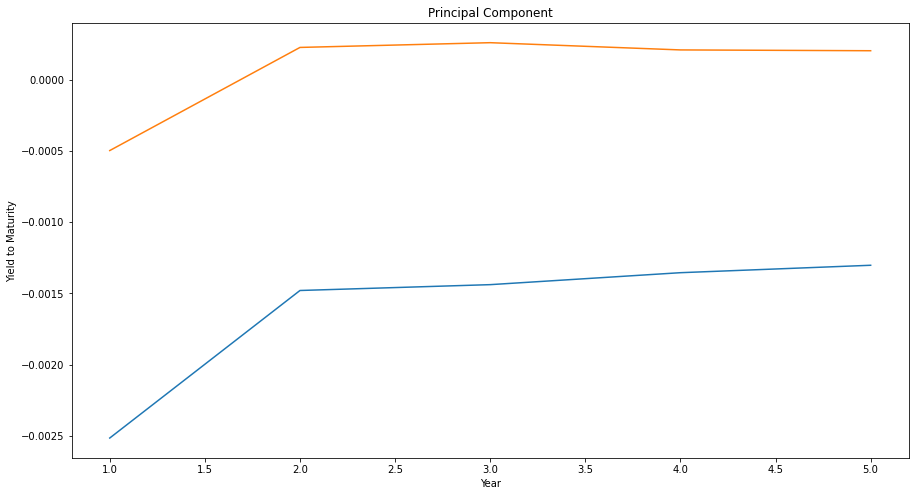

In [31]:
plt.figure(figsize = (15, 8))
plt.plot(x_axis, PC1)
plt.plot(x_axis, PC2)

plt.title("Principal Component")
plt.xlabel("Year")
plt.ylabel("Yield to Maturity")
plt.show()